The goal of this analysis is to identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers. 

We will perform Hierarchical Cluster Analysis (HCA) and Kmeans Clustering Analysis for customer segmentation and profiling. 

In [1]:
# Loading all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import zscore
import sklearn.metrics

from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import gc
# enable garbage collector to aid in memory 
gc.enable()

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading data file and printing the data
bank_df = pd.read_excel("Credit+Card+Customer+Data.xlsx")
bank_df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [3]:
# Printing information of dataset
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


## Data preprocessing

### Missing value check

In [4]:
# Checking missing values in dataframe
bank_df.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

There are no missing values present in the dataset.

### Data Duplicacy Check

Now, I'll check the duplicate records of a customer and will keep the latest/last entry for updated record.

In [5]:
# Checking and dropping duplicated records based on Customer key
bank_df = bank_df.drop_duplicates(subset=['Customer Key'], keep='last')
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 655 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                655 non-null    int64
 1   Customer Key         655 non-null    int64
 2   Avg_Credit_Limit     655 non-null    int64
 3   Total_Credit_Cards   655 non-null    int64
 4   Total_visits_bank    655 non-null    int64
 5   Total_visits_online  655 non-null    int64
 6   Total_calls_made     655 non-null    int64
dtypes: int64(7)
memory usage: 40.9 KB


I have found 5 duplicate records of customers. Therefore, we will keep the latest record of those customers.

In [6]:
# Dropping Non-informative column
bank_df.drop(['Sl_No', 'Customer Key'] , axis=1,inplace=True)

## EDA of dataset with Insights

To start, we need to analyse the data with basic univariate and bi-variate analysis of the dataset. We can describe the dataset by getting stistical information of each feature.

In [7]:
# Getting the summary of bank dataframe
bank_df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,655.000000,655.00000,655.000000,655.000000,655.000000
mean,34563.358779,4.71145,2.404580,2.601527,3.575573
std,37648.200947,2.17241,1.625385,2.920192,2.855867
min,3000.000000,1.00000,0.000000,0.000000,0.000000
25%,10000.000000,3.00000,1.000000,1.000000,1.000000
50%,18000.000000,5.00000,2.000000,2.000000,3.000000
75%,48000.000000,6.00000,4.000000,4.000000,5.000000
max,200000.000000,10.00000,5.000000,15.000000,10.000000


###### Insights:
1. The mean credit limit of customers is around 35k and 5 credit cards with standard deviation of 2. The maximum credit card reported is 200k.
2. The dataset contains people with minimum 1 credit card and maximum 10 credit cards per person. On avergae customers have 4.7 credit cards.
3. On average, customers visit 2.4 times in person, 2.6 times online, and 3.57 through mobile calls. 

### Univariate Analysis

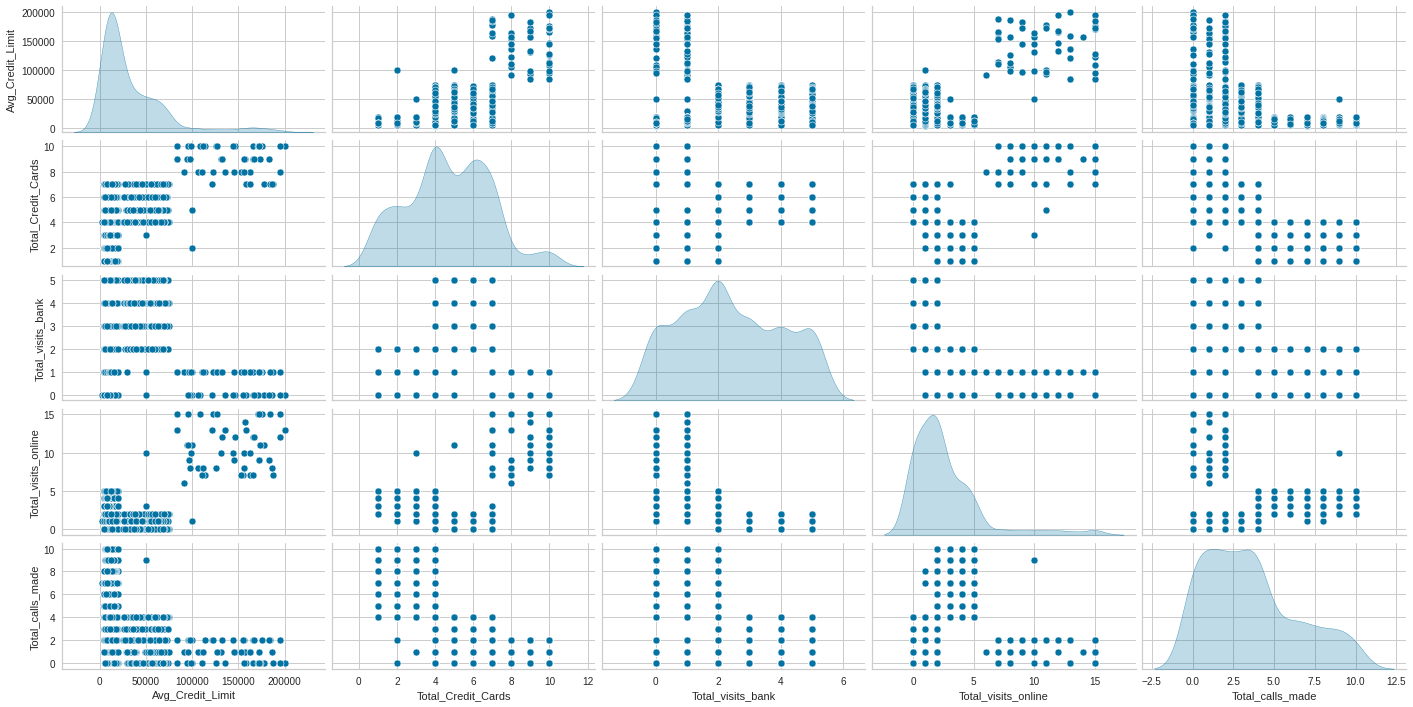

In [8]:
# Statistical plots for each feature
sns.pairplot(bank_df, height=2,aspect=2 , diag_kind='kde')

The pairplot shows the distribution of each feature using histograms and frequency plots. The visualization contains univariate and bi-variate plots of each feature.

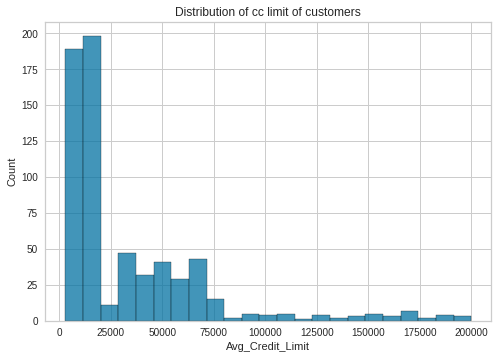

In [9]:
# Analysis and visualization of Average credit cards limit of  customers CC
ax = sns.histplot(x = 'Avg_Credit_Limit',  data=bank_df)
ax.set_title('Distribution of cc limit of customers')
plt.show()

### Outlier Handling

The histogram shows that the average credit limit data distribution is skewed to the right. We need to plot a boxplot of it and hand the outliers present in the column.

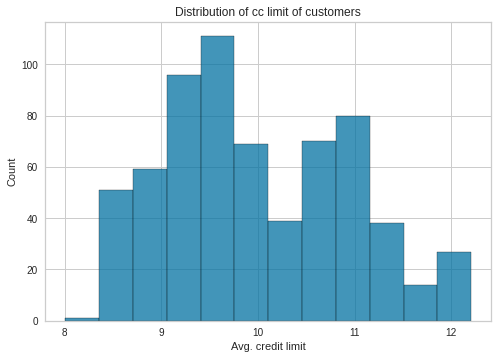

In [10]:
# Convert average credit limit score to log credit limit
bank_df['Avg_Credit_Limit_log'] = np.log(bank_df['Avg_Credit_Limit'])
ax = sns.histplot(x = 'Avg_Credit_Limit_log',  data=bank_df)
plt.xlabel("Avg. credit limit")
ax.set_title('Distribution of cc limit of customers')
plt.show()

Now the data is normally distributed. We can convert back the data to it's normal form after the analysis by taking the exponential of the column.

4     148
6     116
7     101
5      74
2      63
1      59
3      53
10     19
8      11
9      11
Name: Total_Credit_Cards, dtype: int64


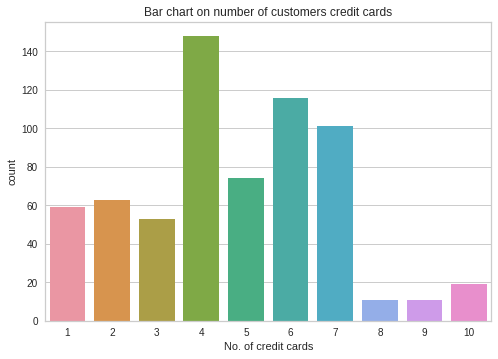

In [11]:
# Analysis and visualization of number of credit cards
tb = bank_df['Total_Credit_Cards'].value_counts()
print(tb)
ax = sns.countplot(x = 'Total_Credit_Cards',  data=bank_df)
plt.xlabel("No. of credit cards")
ax.set_title('Bar chart on number of customers credit cards')
plt.show()

Most of the customers carry 4 to 7 credit cards, and 4.72 on average. Very few customers have 8-10 credit cards.

2    158
1    111
3    100
0     98
5     96
4     92
Name: Total_visits_bank, dtype: int64


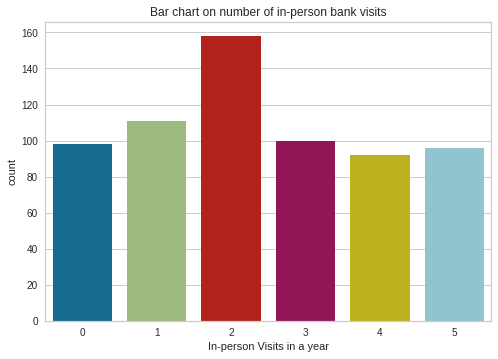

In [12]:
# Analysis and visualization of total in-person bank visits
tb = bank_df['Total_visits_bank'].value_counts()
print(tb)
ax = sns.countplot(x = 'Total_visits_bank',  data=bank_df)
plt.xlabel("In-person Visits in a year")
ax.set_title('Bar chart on number of in-person bank visits')
plt.show()

2     187
0     142
1     109
4      69
5      54
3      44
15     10
7       7
8       6
10      6
11      5
12      5
13      5
9       4
6       1
14      1
Name: Total_visits_online, dtype: int64


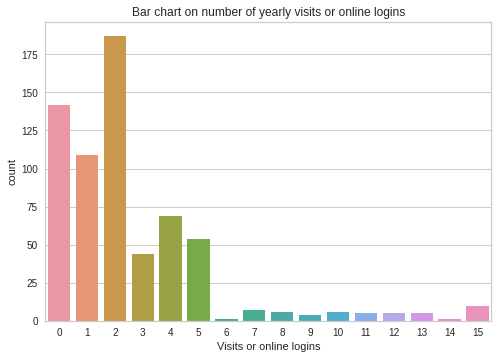

In [13]:
# Analysis and visualization of total visits or online logins in a year
tb = bank_df['Total_visits_online'].value_counts()
print(tb)
ax = sns.countplot(x = 'Total_visits_online',  data=bank_df)
plt.xlabel("Visits or online logins")
ax.set_title('Bar chart on number of yearly visits or online logins')
plt.show()

Majority of the customers have made 0 to 5 online visits or login to the bank in a year. 

4     108
0      96
1      90
2      90
3      82
6      39
7      35
9      32
5      29
8      29
10     25
Name: Total_calls_made, dtype: int64


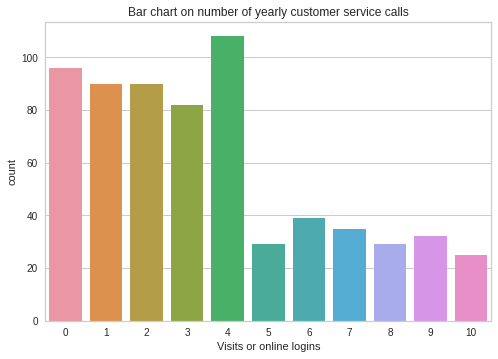

In [14]:
# Analysis and visualization of total number of calls made in a year
tb = bank_df['Total_calls_made'].value_counts()
print(tb)
ax = sns.countplot(x = 'Total_calls_made',  data=bank_df)
plt.xlabel("Visits or online logins")
ax.set_title('Bar chart on number of yearly customer service calls')
plt.show()

Most people are making 0 to 4 online logins to the bank portal in a year.

### Bi-variate Analysis

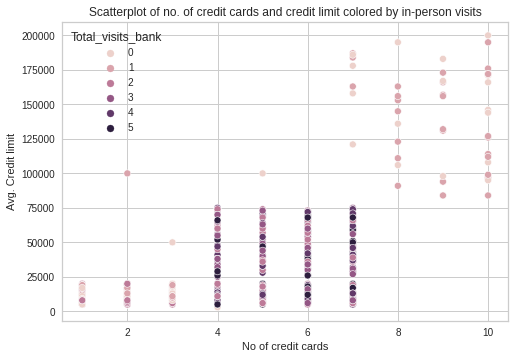

In [15]:
# Visualization of cutomers credit card limit and number of cards with total in person bank visits
ax = sns.scatterplot(x='Total_Credit_Cards', y = 'Avg_Credit_Limit', hue = 'Total_visits_bank', data=bank_df)
plt.xlabel("No of credit cards")
plt.ylabel("Avg. Credit limit")
ax.set_title('Scatterplot of no. of credit cards and credit limit colored by in-person visits')
plt.show()

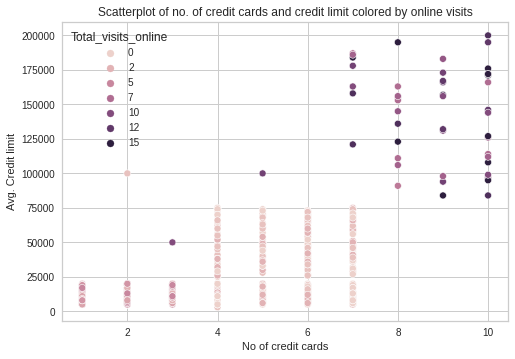

In [16]:
# Visualization of cutomers credit card limit and number of cards with totat online visits
ax = sns.scatterplot(x='Total_Credit_Cards', y = 'Avg_Credit_Limit', hue = 'Total_visits_online' ,data=bank_df)
plt.xlabel("No of credit cards")
plt.ylabel("Avg. Credit limit")
ax.set_title('Scatterplot of no. of credit cards and credit limit colored by online visits')
plt.show()

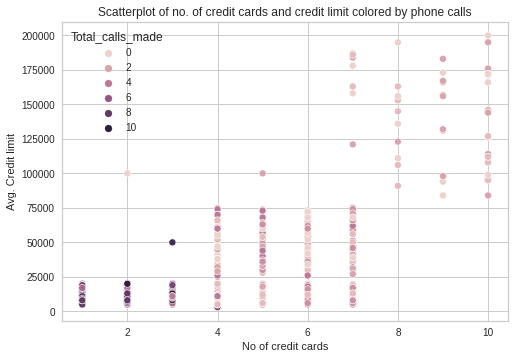

In [17]:
# Visualization of cutomers credit card limit and number of cards with totat phone calls made
ax = sns.scatterplot(x='Total_Credit_Cards', y = 'Avg_Credit_Limit', hue = 'Total_calls_made' ,data=bank_df)
plt.xlabel("No of credit cards")
plt.ylabel("Avg. Credit limit")
ax.set_title('Scatterplot of no. of credit cards and credit limit colored by phone calls')
plt.show()

#####  Insights and Recommendations
1. The above scatterplot shows a positive correlation between number of credit cards owned by the customer and credit limit. 
2. From fig.1 we can see that people owning 4-7 credit cards have lower credit limits and prefer more in-person visits compared to people with higher or lower number of credit card owners.
3. People with more than 7 credit cards prefer to use online banking or portal services compared to others.
4. Fig.3 shows that people with 1-3 credit cards prefer making phone calls for services or dealing with issues. 

## Machine Learning

After the basic EDA of the dataset, we can proceed with the machine learning. For customer segmentation, we will run HCA and KMeans clustering algorithm with the optimal parameters for the best perforamce and visualize the results with the help of relevent plots.

In [18]:
# Dropping original credit limit column after analysis and keeping a copy of original dataset
bank_df_original = bank_df.drop(['Avg_Credit_Limit_log'], axis=1).copy()
bank_df.drop(['Avg_Credit_Limit'], axis = 1, inplace=True)

Before performing the clustering analysis, we need to scale the data as we will be taking Euclidean distance as a matric. Getting Zscore of each column is one of the best statistical method for data standardization.

In [19]:
# Data Standardization before clustering
bank_scaled_df=bank_df.apply(zscore)
bank_scaled_df.head(10)

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_Credit_Limit_log
0,-1.249084,-0.864813,-0.548851,-1.252966,1.631391
1,-0.788414,-1.480522,2.535493,1.900849,0.885986
2,1.054266,-0.864813,0.136559,0.148730,0.885986
3,0.132926,-0.864813,-0.548851,0.148730,0.336649
5,-0.788414,-1.480522,-0.548851,1.550425,-0.099385
6,0.132926,-1.480522,2.878198,-0.552118,1.631391
7,-0.788414,-1.480522,-0.548851,-0.902542,-0.408756
8,-1.249084,-1.480522,-0.206146,-0.552118,-1.590195
9,-0.327744,-1.480522,-0.548851,1.200001,-2.139532
10,-0.327744,-1.480522,0.821969,0.499153,-0.844790


### Hierarchial Clustering Analysis

We can start HCA with getting the optimal parameters for the algorithm by experimenting with multiple metrics parameters like distance, methods etc. We will calcualate Z score of each method, and will pick the model with the highest Z score.

In [20]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

# Calculating Z score for single method with euclidean distance
Z = linkage(bank_scaled_df, metric='euclidean', method='single')
c, coph_dists = cophenet(Z , pdist(bank_scaled_df))
print("Method Single Score : ",c)

# Calculating Z score for complete method with euclidean distance
Z = linkage(bank_scaled_df, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(bank_scaled_df))
print("Method Complete Score : ",c)

# Calculating Z score for average method with euclidean distance
Z = linkage(bank_scaled_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(bank_scaled_df))
print("Method Average Score : ",c)

# Calculating Z score for ward method with euclidean distance
Z = linkage(bank_scaled_df, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(bank_scaled_df))
print("Method Ward Score : ",c)

Method Single Score :  0.6913175139671595
Method Complete Score :  0.8417604995465271
Method Average Score :  0.8702112208842004
Method Ward Score :  0.7449558040281822


Since, Average linkage is performing the best from all other methods, we will keep linkage as Average with Euclidean distance. Now we can visualize the clustering to get a better understanding of optimal value of number of clusters.

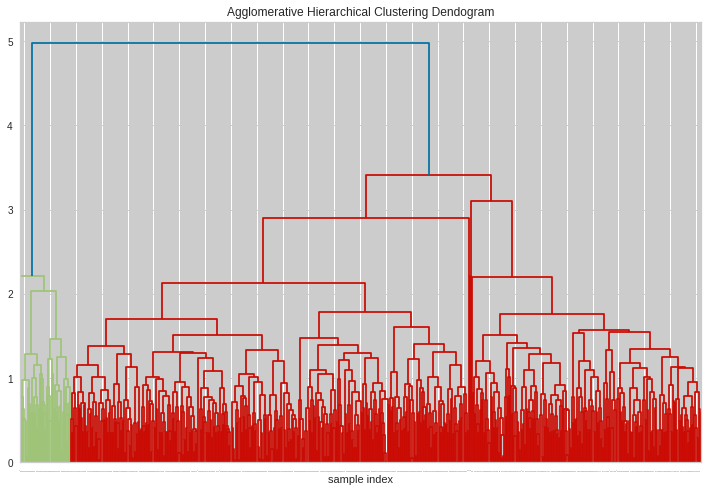

In [21]:
# Visualization to plot the best plot using average method and euclidean distance for clustering.
Z = linkage(bank_scaled_df, metric='euclidean', method='average')
plt.figure(figsize=(10, 7))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
dendrogram(Z,leaf_font_size=0.)
plt.tight_layout()

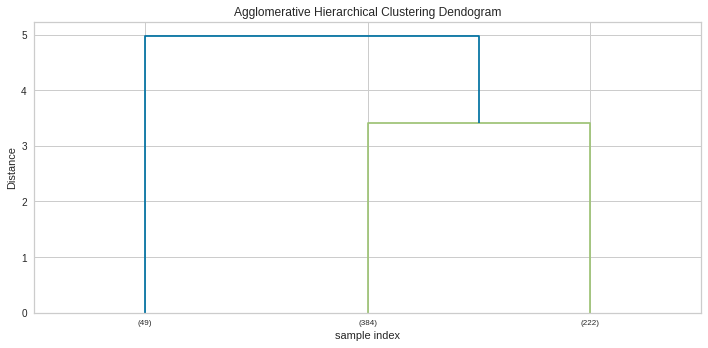

In [22]:
# Plotting selected cluster in Hierarchical Clustering showing total number of customers in each custmor segment.
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, truncate_mode='lastp', leaf_font_size=8, p = 3)
plt.tight_layout()


We can see from the visualization that n = 3 is the optimal value of cluster.

In [23]:
# Agglomerative HCA clustering using best paramters and number of clusters
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
model.fit(bank_scaled_df)
label = model.labels_

In [24]:
# Inserting labels into original dataset for analysis and performance comparision
HCA_df = bank_df_original.copy()
HCA_df['labels'] = model.labels_

# Printing top 10 rows of clusters data
HCA_df.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,2
1,50000,3,0,10,9,0
2,50000,7,1,3,4,2
3,30000,5,1,1,4,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,1
7,15000,3,0,1,1,2
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0
10,10000,4,0,5,5,0


### K-means Clustering

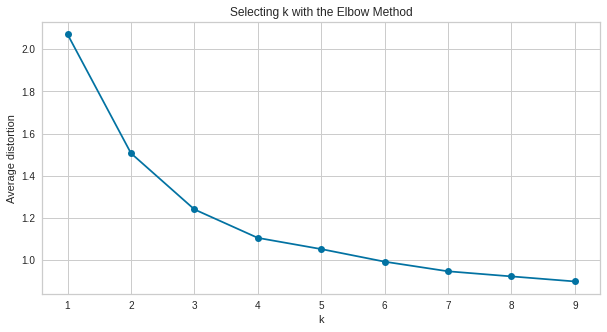

In [25]:
# Performaing Kmeans clustering on the bank scaled data

#Finding optimal no. of clusters
clusters=range(1,10)
meanDistortions=[]

# Applying clustering for 10 k values to pick the best one
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(bank_scaled_df)
    prediction=model.predict(bank_scaled_df)
    
    # Calculating the WSS of each model
    meanDistortions.append(sum(np.min(cdist(bank_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / bank_scaled_df.shape[0])

# Plotting the WSS vs K plot 
plt.figure(figsize=(10, 5))
plt.plot(clusters, meanDistortions, 'bo-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

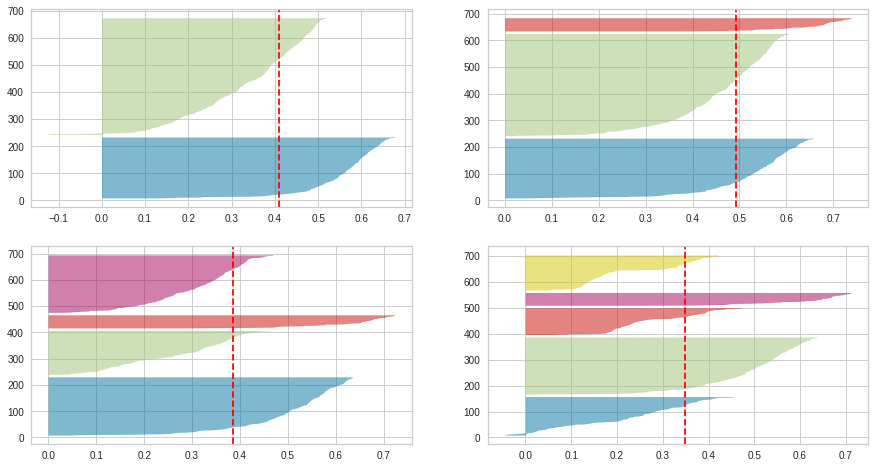

In [26]:
fig, axis = plt.subplots(2, 2, figsize=(15,8))

# plot silhoutte plot for k from 2-5 to pick the optimal value.
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, random_state=1)
    q, mod = divmod(i, 2)
    
    # Fitting the model into  visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax = axis[q-1][mod])
    visualizer.fit(bank_scaled_df)

The knee of the elbow curve is bending at k = 3. Therefore, we will pick k = 3 as the optimal number of cluster for Kmeans clustering.

Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are. For the plot with n_cluster 3, The silhoutte score is highest and the thickness is more uniform than others. Thus, we can select the optimal number of clusters as 3.


In [27]:
# Let us first start with K = 3
final_model=KMeans(3, random_state=1).fit(bank_scaled_df)
prediction=final_model.predict(bank_scaled_df)

#Append the prediction 
kmeans_df = bank_df_original.copy()
kmeans_df["labels"] = prediction
kmeans_df.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0
10,10000,4,0,5,5,0


### Comparision of Kmeans and HCA clusters

We can analyse the results of HCA and Kmeans clustering with the help of visualizations. The basic method for analysis is to make a scatterplot between any two features and coloring each datapoint with the cluster label. 

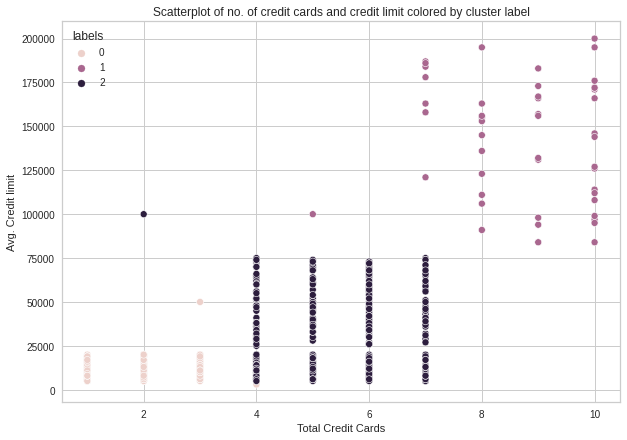

In [28]:
# Scatterplot for HCA clustering results with cluster label
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x='Total_Credit_Cards', y = 'Avg_Credit_Limit', hue = "labels",data=HCA_df)
plt.xlabel("Total Credit Cards")
plt.ylabel("Avg. Credit limit")
ax.set_title('Scatterplot of no. of credit cards and credit limit colored by cluster label')
plt.show()

The three clusters are well separated with distinguished color. The cluster 0 is covering bottom-left data points, cluster 1 covering top-right datapoints, and cluster 2 covering middle customers with 4 to 7 credit cards.

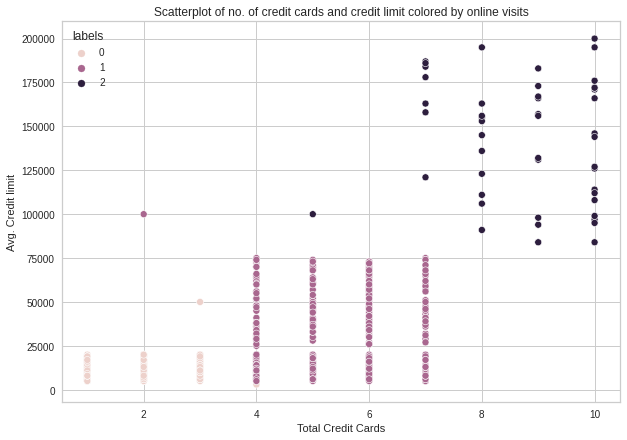

In [29]:
# Scatterplot for Kmeans clustering results with cluster label
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x='Total_Credit_Cards', y = 'Avg_Credit_Limit', hue = "labels",data=kmeans_df)
plt.xlabel("Total Credit Cards")
plt.ylabel("Avg. Credit limit")
ax.set_title('Scatterplot of no. of credit cards and credit limit colored by online visits')
plt.show()

Kmeans clustering performed similer to HCA clustering with three number of clusters. All the clusters are well separated with distinguished color. The cluster 0 is covering bottom-left data points, cluster 1 covering middle datapoints, and cluster 2 covering top-right customers with more than 7 credit cards.

In [30]:
# hierarchical clustering  Analysis

# Customer segmentations count
print("\nTotal Customers in each group: \n", HCA_df['labels'].value_counts())

# Cluster mean analysis
HCA_df.groupby(['labels']).mean()



Total Customers in each group: 
 2    384
0    222
1     49
Name: labels, dtype: int64


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,12144.144144,2.414414,0.945946,3.572072,6.864865
1,141877.551020,8.795918,0.612245,10.877551,1.040816
2,33830.729167,5.518229,3.476562,0.984375,1.997396


##### Insights:
1. The cluster 0 has customers with low credit limit and they own around 2.42 credit cards on average. Their bannk visit preference is mostly via mobile or phone call.

2. Cluster 1 has high credit limit customers with high number of credit cards. They prefer to make online visits via the portal for bank related queries.

3. CLuster 2 have mid average compared to others and have 5.5 credit cards on average. They prefer to visit bank in person for queries.

In [31]:
# Kmeans clustering  Analysis

# Customer segmentations count
print("\nTotal Customers in each group: \n", kmeans_df['labels'].value_counts())

# Cluster mean analysis
kmeans_df.groupby(['labels']).mean()


Total Customers in each group: 
 1    383
0    223
2     49
Name: labels, dtype: int64


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,12156.950673,2.417040,0.941704,3.560538,6.838565
1,33879.895561,5.524804,3.485640,0.984334,2.000000
2,141877.551020,8.795918,0.612245,10.877551,1.040816


##### Insights:

The Kmeans cluster gave identical results to HCA cluster. 

1. The cluster 0 has customers with low credit limit and they own around 2.42 credit cards on average. Their bannk visit preference is mostly via mobile or phone call.

2. Cluster 2 have mid average compared to others and have 5.5 credit cards on average. They prefer to visit bank in person for queries.

2. Cluster 3 has high credit limit customers with high number of credit cards. They prefer to make online visits via the portal for bank related queries.


Both the algorithm performed good on AllLife Bank Customer Segmentation data for customer query. The clusters given by HCA and Kmeans are identical, which proves that both algorithm perfomed good. The mean score tables shows that the clusters are far away from each other and have distinguishe results.

### Actionable Insights & Recommendations

The analysis includes insights throughout the notebook. Based on those insights and customer Segmentation we can recommend the bank the following - 

The mid credit limit customers (Cluster 1 in Kmeans) are making in-person visits for queries resolution, the bank needs to look into that issue and figure out why that is happening. These in-person visits can be minimized by portal or mobile phone calls customer services.


